In [1]:
from brian2 import *
# set_device('cpp_standalone') # for faster execution - builds a standalone C++ program

import NeuronEquations
import BrianHF
import numpy as np

from bimvee.importAe import importAe
from EvCamDatabase import DAVIS_346B
import os

import time

# TODO XXX: Turn all lists into numpy arrays for the sake of memory efficiency

WARNING    /home/bernard/Desktop/IIT_Thesis/ERO-SNN/BrianHF.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
 [py.warnings]


In [2]:
# XXX: Extract the event stream using bimvee - needs refactoring to be more general
grid_width, grid_height= DAVIS_346B['width'], DAVIS_346B['height']
filePath = 'MVSEC_short_outdoor'
events = importAe(filePathOrName=filePath)

{'filePathOrName': 'MVSEC_short_outdoor'}
{'filePathOrName': 'MVSEC_short_outdoor'}
{'filePathOrName': 'MVSEC_short_outdoor/rightdvs'}
{'filePathOrName': 'MVSEC_short_outdoor/rightdvs'}
importIitYarp trying path: MVSEC_short_outdoor/rightdvs


100%|██████████| 38024/38024 [00:07<00:00, 5339.20it/s]


Examining info.log: MVSEC_short_outdoor/rightdvs/info.log
{'filePathOrName': 'MVSEC_short_outdoor/leftdvs'}
{'filePathOrName': 'MVSEC_short_outdoor/leftdvs'}
importIitYarp trying path: MVSEC_short_outdoor/leftdvs


100%|██████████| 38292/38292 [00:06<00:00, 5744.63it/s] 


Examining info.log: MVSEC_short_outdoor/leftdvs/info.log


In [3]:
try:
    eventStream = events[0]['data']['left']['dvs']
except:
    eventStream = events[0]['data']['right']['dvs']
eventStream.popitem()

('tsOffset', -0.0)

### Steps for the setting up the network:
1. Generate the input spikes
2. Set the parameters for the network (neurons and synapses)
3. Create the neuron group(s)
4. Create the synapses
5. Connect the synapses
6. Define the weights of the synapses
7. Set up monitors according to need
8. Run the simulation
9. (Optional) Visualize the results

#### _1. Generate the input spikes from the event stream_
###### _Brian Simulation Scope_


In [4]:
# HACK XXX: The input is now not in real time, must be fixed eventually to process real time event data
# IMPORTANT NOTE: Output is float, so we need to convert to Quantities (i.e give them units)


# Simulation Parameters
defaultclock.dt = 0.05*ms
SaveNumpyFrames = False
GenerateGIFs = False


simTime, clockStep, inputSpikesGen = BrianHF.event_to_spike(eventStream, grid_width, grid_height, dt = defaultclock.dt, timeScale = 1.0, samplePercentage=1.0)
# defaultclock.dt = clockStep*ms
print("Input event stream successfully converted to spike trains\n")

Extracting the event data...
Polarity was chosen to be ignored. All events are extracted.
Selecting a percentage of the spikes at regular intervals... Percentage:  0.01 %
The maximum x index 345 while the width is 346
The maximum y index 258 while the height is 260
The x,y and time stamp indices are equal, the data is correct.
Checking for duplicate pairs...
No duplicate pairs found.
Total number of pairs/spikes:  692  pairs.
The selected scale is 1.0
The maximum time stamp (scaled) 19977.294 ms.
The recommended simulation time (scaled) is 19978.0 ms.
The minimum time step (scaled) is 2038.6459999999997 ms.
The recommended clock time step (scaled) is 2038.646 ms.
Input event stream successfully converted to spike trains



#### _2. Set the parameters for the network (neurons and synapses)_
Parameter values can be tuned per namespace(this is done for clarity purposes).

In [5]:
# NOTE: The values are unitless for now, time constants are in ms simply to be able to tune to the simulation clock

# Neuron Parameters
N_Neurons = grid_width * grid_height    # Number of neurons

Neuron_Params = {'tau': 0.1*ms, 'tauSpi': 0.5*ms, 'vt': 1.0, 'vr': 0.0, 'P': 0, 'incoming_spikes': 0, 'method_Neuron': 'rk2'}
tau = Neuron_Params['tau']
tauSpi = Neuron_Params['tauSpi']
vt = Neuron_Params['vt']
vr = Neuron_Params['vr']
P = Neuron_Params['P']
incoming_spikes = Neuron_Params['incoming_spikes']

Eqs_Neurons = NeuronEquations.EQ_SCM_IF    # Neurons Equation
 
# Synapse Parameters
'''
Neighborhood Size (num_Neighbors) - Affects the number of neighbors a central neuron based on the L1 Distance
Neighboring Neurons --> (abs(X_pre - X_post) <= Num_Neighbours  and abs(Y_pre - Y_post) <= Num_Neighbours)
'''
Syn_Params = {'Num_Neighbours' : 2, 'beta': 1.5, 'Wi': 11.3, 'Wk': -2.0, 'method_Syn': 'rk2'}
Num_Neighbours = Syn_Params['Num_Neighbours']
beta = Syn_Params['beta']
Wi = Syn_Params['Wi']
Wk = Syn_Params['Wk']

# Generate the dictionary of parameters for the network
networkParams = {**Neuron_Params, **Syn_Params, 'Sim_Clock': defaultclock.dt}

#### _3. Create the neuron group(s)_

In [6]:
print('Creating Neuron Groups...')

Creating Neuron Groups...


In [7]:
# TODO XXX: The events are running on the clockStep, I should at least fix them to use the (event_driven) setting in Brian2
neuronsGrid = NeuronGroup(N_Neurons, Eqs_Neurons, threshold='v>vt',
                            reset='''
                            v = vr
                            incoming_spikes_post = 0
                            ''',
                            refractory='0*ms',
                            events={'P_ON': 'v > vt', 'P_OFF': '(timestep(t - lastspike, dt) > timestep(dt, dt) and v <= vt)'},
                            method= 'euler',
                            namespace=Neuron_Params)


# Define the created events, the actions to be taken as well as when they should be evaluated and executed
neuronsGrid.run_on_event('P_ON', 'P = 1' , when = 'after_thresholds')
neuronsGrid.set_event_schedule('P_OFF', when = 'before_groups')
neuronsGrid.run_on_event('P_OFF', 'P = 0', when = 'before_groups')

# FIXME: Verify the grid coordinates and assign the X and Y values to the neurons accordingly
# Generate x and y values for each neuron
x_values = np.repeat(np.arange(grid_width), grid_height)
y_values = np.tile(np.arange(grid_height), grid_width)
neuronsGrid.X = x_values
neuronsGrid.Y = y_values

In [8]:
print('Neuron Groups created successfully\n')

Neuron Groups created successfully



#### _4. Create the synapses_

In [9]:
print('Creating Synapse Connections...')

Creating Synapse Connections...


In [10]:
Syn_Input_Neurons = Synapses(inputSpikesGen, neuronsGrid, 'beta : 1 (constant)', on_pre='ExtIn_post = beta')

# NOTE: In hopes of reducing simulation time, I am using _pre keyword to avoid the need for an autapse. Hence only one Synapse group is needed
Syn_Neurons_Neurons = Synapses(neuronsGrid, neuronsGrid,
                               '''
                               Wi : 1 (constant)
                               Wk : 1 (constant)
                               ''',
                               on_pre={
                                   'pre':'incoming_spikes_post += 1; Exc_pre = Wi',
                                   'after_pre': 'Inh_post = clip(Inh_post + Wk * incoming_spikes_post/N_outgoing, Wk, 0)'},
                               method= 'euler',
                               namespace=Syn_Params)

#### _5. Connect the synapses_

In [11]:
# Connect the first synapses from input to G_neurons on a 1 to 1 basis
Syn_Input_Neurons.connect(j='i') 
Syn_Input_Neurons.beta = beta

In [12]:
# Connect the inhibitory group of synapses from a neuron to its neighbors. Reminder: No need for autapses as we are using _pre
Syn_Neurons_Neurons.connect(condition='i != j and abs(X_pre - X_post) <= Num_Neighbours and abs(Y_pre - Y_post) <= Num_Neighbours')
Syn_Neurons_Neurons.Wi = Wi
Syn_Neurons_Neurons.Wk = Wk

In [13]:
print('Synapse Connections created successfully\n')

Synapse Connections created successfully



#### _6. Set up monitors_

In [14]:
SpikeMon_Input = SpikeMonitor(inputSpikesGen)    # Monitor the spikes from the input
SpikeMon_Neurons = SpikeMonitor(neuronsGrid)    # Monitor the spikes from the neuron grid
# StateMon_Neurons = StateMonitor(neuronsGrid, variables=True, record=True)    # Monitor the state variables - True for all variables. NOTE: WARNING!! Excessive memory usage

### 7. Run the simulation_

In [15]:
print(f"Running the simulation for {simTime} ms")
if 'ipykernel' in sys.modules:
    # Running in a Jupyter notebook
    print("Running in a Jupyter notebook")
    run(simTime*ms, profile=True)
    # profiling_summary(net)
else:
    # Not running in a Jupyter notebook
    print("Not running in a Jupyter notebook")
    run(simTime*ms, report=BrianHF.ProgressBar(), report_period=1*second, profile=True)
    # print(profiling_summary(net))
print("Simulation complete\n")

WARNING    'P' is an internal variable of group 'neurongroup', but also exists in the following namespaces: group-specific ,run. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Running the simulation for 19978.0 ms
Running in a Jupyter notebook


WARNING    'Wk' is an internal variable of group 'synapses_1', but also exists in the following namespaces: group-specific ,run. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'Inh_post = clip(Inh_post + ((Wk * incoming_spikes_post) / N_outgoing), Wk, 0)'
 [brian2.codegen.generators.base]
WARNING    'Wi' is an internal variable of group 'synapses_1', but also exists in the following namespaces: group-specific ,run. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matte

Simulation complete



#### _9. (Optional) Visualize the results_

In [16]:
print("Generating Visualizable Outputs:")
resultPath = 'SimulationResults'
inputStr = BrianHF.filePathGenerator('tempnetIn', networkParams)
outputStr = BrianHF.filePathGenerator('tempnetOut', networkParams)

# Create the folder if it doesn't exist
if not os.path.exists(resultPath):
    os.makedirs(resultPath)

# Create the subfolders if they don't exist
subfolders = ['numpyFrames', 'gifs', 'videos']
for subfolder in subfolders:
    subfolderPath = os.path.join(resultPath, subfolder)
    if not os.path.exists(subfolderPath):
        os.makedirs(subfolderPath)

Generating Visualizable Outputs:


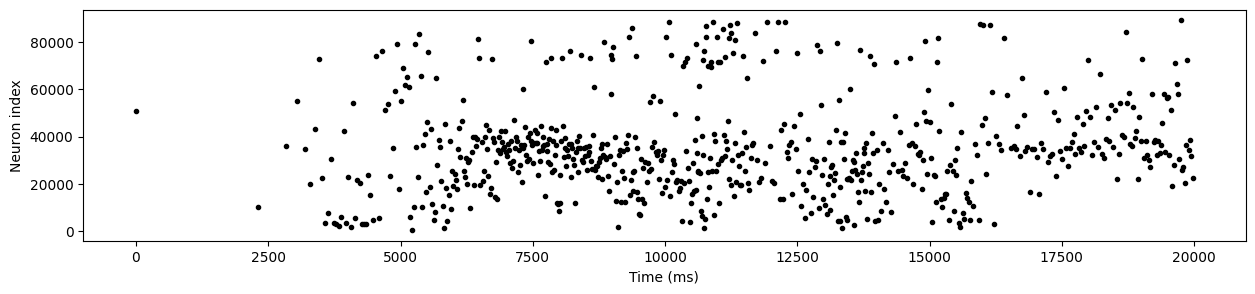

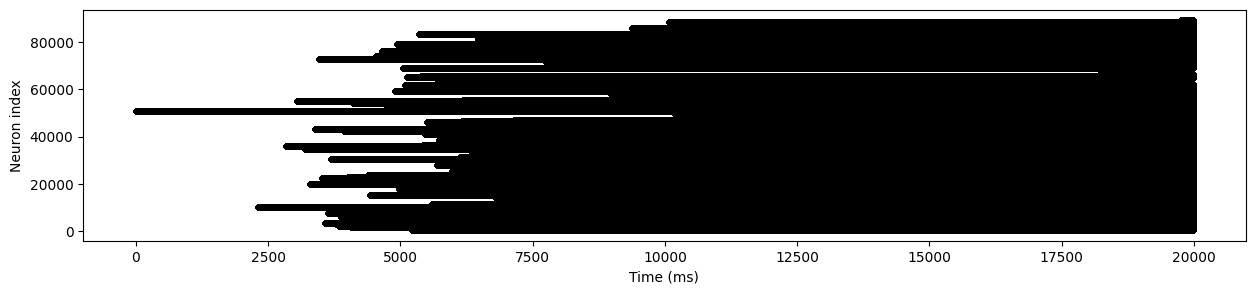

In [17]:
# BrianHF.visualise_connectivity(Syn_Input_Neurons)
BrianHF.visualise_spikes([SpikeMon_Input, SpikeMon_Neurons])
# BrianHF.visualise_spike_difference(SpikeMon_Input, SpikeMon_Neurons)

In [ ]:
# Generate the frames for input and output
print("Generating Frames for Input...", end=' ')
inputFrames = BrianHF.generate_frames(SpikeMon_Input, grid_width, grid_height, num_neurons=N_Neurons)
print("Generation Complete.")
print("Generating Frames for Output...", end=' ')
outputFrames = BrianHF.generate_frames(SpikeMon_Neurons, grid_width, grid_height, num_neurons=N_Neurons)
print("Generation Complete.")

if SaveNumpyFrames:
    # Save the frames
    for name, frames in [(inputStr, inputFrames), (outputStr, outputFrames)]:
        filename = os.path.join(resultPath, 'numpyFrames', name+'.npy')
        if os.path.exists(filename):
            filename = os.path.join(resultPath, 'numpyFrames', f"{name}_{int(time.time())}.npy")
        np.save(filename, frames)

if GenerateGIFs:
    # Generate the GIFs from the frames
    for name, frames in [(inputStr, inputFrames), (outputStr, outputFrames)]:
        filename = os.path.join(resultPath, 'gifs', name+'.gif')
        if os.path.exists(filename):
            filename = os.path.join(resultPath, 'gifs', f"{name}_{int(time.time())}.gif")
        BrianHF.generate_gif(frames, filename, simTime, replicateDuration=True, duration=1e-8)

# Generate the Videos from the frames
for name, frames in [(inputStr, inputFrames), (outputStr, outputFrames)]:
    filename = os.path.join(resultPath, 'videos', name+'.mp4')
    if os.path.exists(filename):
        filename = os.path.join(resultPath, 'videos', f"{name}_{int(time.time())}.mp4")
    BrianHF.generate_video(frames, filename, simTime/1000)

In [1]:
# Generate the frames for input and output
print("Generating Frames for Input...", end=' ')
inputFrames = BrianHF.generate_frames(SpikeMon_Input, grid_width, grid_height, num_neurons=N_Neurons)
print("Generation Complete.")
print("Generating Frames for Output...", end=' ')
outputFrames = BrianHF.generate_frames(SpikeMon_Neurons, grid_width, grid_height, num_neurons=N_Neurons)
print("Generation Complete.")

if SaveNumpyFrames:
    # Save the frames
    np.save(os.path.join(resultPath, 'numpyFrames', inputStr+'.npy'), inputFrames)
    np.save(os.path.join(resultPath, 'numpyFrames', outputStr+'.npy'), outputFrames)

GenerateGifs = False
if GenerateGIFs:
    # Generate the GIFs from the frames
    print("Generating Input GIF", end=' ')
    BrianHF.generate_gif(inputFrames, os.path.join(resultPath, 'gifs', inputStr+'.gif'), simTime, replicateDuration=True, duration=1e-8)
    print("Generation Complete.")
    print("Generating Output GIF", end=' ')
    BrianHF.generate_gif(outputFrames, os.path.join(resultPath, 'gifs', outputStr+'.gif'), simTime, replicateDuration=True ,duration=1e-8)
    print("Generation Complete.")

# Generate the Videos from the frames
print("Generating Input Video", end=' ')
BrianHF.generate_video(outputFrames, os.path.join(resultPath, 'videos', inputStr+'.mp4'), simTime/1000)
print("Generation Complete.")
print("Generating Output Video", end=' ')
BrianHF.generate_video(outputFrames, os.path.join(resultPath, 'videos', outputStr+'.mp4'), simTime/1000)
print("Generation Complete.")

Generating Frames for Input... 

NameError: name 'BrianHF' is not defined

In [ ]:
# store('SimOut', 'SimulationOutput')   # Store the state of the simulation after running

"""
I SHOULD REMOVE THIS
%%
VISUALISATION
BrianHF.visualise_spikes([SpikeMon_Input], figSize=(12,3), figTitle='Input Spikes')
BrianHF.visualise_spikes([SpikeMon_Neurons], figSize=(12,3), figTitle='Output Spikes')

Ploting the interspike interval
BrianHF.visualise_interSpikeInterval(SpikeMon_Neurons, [5])
BrianHF.visualise_neurons_states(StateMon_Neurons, [4, 5], 'all')    
